<a href="https://colab.research.google.com/github/mannixp/CHIST/blob/main/PDF_Construction_using_extruded_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update --fix-missing

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

**Part 2 - Computing the PDF**

**A) Theory**

Having constructed the CDF $F(y)$ we now turn to constructing its PDF $f(y)$ which must remain positive and integrate to one. While strictly speaking the PDF is the derivative of the CDF, the CDF obtained in **Part 1** is clearly discontinous and constructing a finite element basis for $V_F$ with continuous first derivatives is perhaps unescessary if we can contend ourselves with $f(y)$ being only weakly differentiable. To this end we choose to recover the PDF via a projection as this requires less regularlity. To do so define the function space $V_f $ of $f(y)$ to be
\begin{equation*}
    f \in V_f \subset H^1(\Omega_Y), \quad \text{where} \quad f:\Omega_Y \to \mathbb{R}^+ \quad \text{s.t.} \; \left\{ \int f^2 dy < \infty, \int |\nabla f|^2 dy < \infty \right\},
\end{equation*}
thus allowing for weak derivatives followed by a set of basis functions $V_f = span\{\varphi_i(y)\}$ such that
\begin{equation*}
    f(y) = \sum_i f_i \varphi_i(y).
\end{equation*}
We then define the projection in each element $e$ as
\begin{equation*}
    \int_{e} \varphi_e f(y) \; dy = \int_{e} \varphi_e \partial_y F(y) \; dy, \quad \text{where} \quad \forall \varphi_e \in V_{e},
\end{equation*}
which (although not strictly valid as $F(y)$ cannot be differentiated) can be integrated by parts in order to put the derivative onto $v$ thus resulting in a boundary flux
\begin{equation*}
    \int_{e} \varphi_e f(y) \; dy = -\int_{e} F(y) \partial_y \varphi_e \; dy + \int_{\partial e} F \varphi_e \cdot \vec{n}_e \; dS, \quad \text{where} \quad \forall \varphi_e \in V_{e},
\end{equation*}
and $\vec{n}_e$ is the outward pointing unit normal. Since $F$ is discontinuous we have to choose how it is defined at the element facets. To ensure that $f$ is projected from a consistent cumulative distribution function i.e. a function $F$ that is right continuous, we must choose upwinding. That is we choose $F=F_+$ at the interior facets.

Summing the contribution of all the elements $\sum_e \int_e \cdot \; dy = \int_{\Omega_Y} \cdot \; dy$ we obtain
\begin{align}
    \int_{\Omega_Y} v f(y) \; dy = & - \int_{\Omega_Y}        F(y) \partial_y v \; dy \\
                                   & + \int_{\Gamma_{int}}    F_+ v \cdot \vec{n}_e \; dS \\
                                   & + \int_{\Gamma_{max(y)}} F v \cdot \vec{n} \; ds \\
                                   & + \int_{\Gamma_{min(y)}} F v \cdot \vec{n} \; ds \quad \forall v \in V_{f},
\end{align}
where the terms on the right hand side correspond to the cell integral, the integral over the set of all interior facets $\Gamma_{int}$ (which vanishes when we upwind or make any consistent choice of $F$ at the facets for that matter) and the integral at the right and left most boundaries. To see that the terms corresponding to the interior facets vanish, consider the fact that at each cell boundary $v \cdot \vec{n}_e$ has the same value albeit with a different sign for the left and right hand cells. Thus if $F$ is chosen in a consistent manner such that it takes a single value at the facet then these terms cancel.


For the PDF $f(y)$ we will choose a piecewise linear function space $V_f$ for $f(y)$ that is continuous between elements 'CG1'. This choice is justified by the need for $f(y)$ to be weakly differentiable, however any piecewise continuous function of higher order is also possible. In **Part 1** a discontinuous piecewise linear function space for $F(y)$ was justfied by the need to maintain a non-decreasing and right-continuous function, which can be achieved by applying a slope limiter. Although this would be also gauranteed by choosing the function space of piece-wise constant discontinuous functions 'DG0', the projection of the derivative of the CDF would then be undefined at its endpoints. As such 'DG1' is the lowest order function-space we can choose for this projection to suceed in producing a higher order approximnation of the CDF as well as a continuous PDF.

**B) Numerical implementation**

To demonstrate our method of recovering the CDF from the PDF we will make use of CDF $F(y)$ and its assciated mesh from **Part 1**. To simplify the presentation we use the *NumDF* library (imported below) which implements the methods used in Part 1. 

In [7]:
from numdf import Ptp
import numpy as np
from firedrake import *

We begin by creating an instance of the *Ptp* class by specify the phyiscal domain $\Omega_X$, the domain of the CDF $\Omega_Y$ and a number of elements. As justified in Part1 a discontinuous piecewise linear 'DG1' function space is selected by default for the CDF.

In [22]:
# Specify the domain sizes and number of elements
ptp = Ptp(Omega_X = {'x1': (0, 2*np.pi)}, Omega_Y = {'Y': (0, 1)}, n_elements=50)

We then specify our function $Y(x_1)$ in terms of the coordinates of the domain and generate its CDF by calling the fit method.

In [23]:
# Extract the coordinates
x1 = ptp.x_coords()
density = ptp.fit(Y = sin(x1)**2, quadrature_degree=2000)

Using the density object we can then plot the CDF.

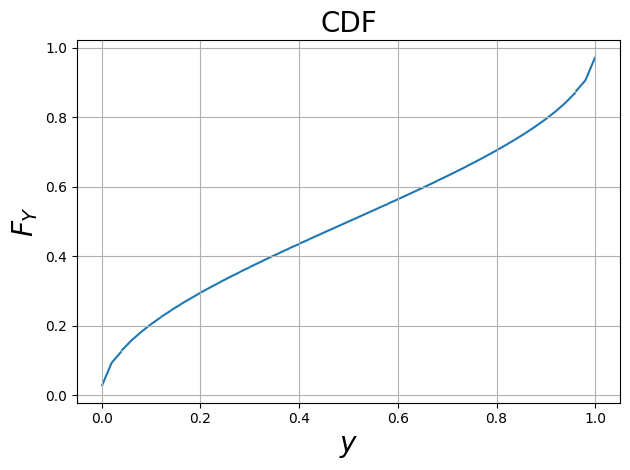

In [24]:
density.plot('CDF')

Reusing the mesh constructed for the CDF $F(y)$ we specify a piecewise linear function space $V_f$ for $f(y)$ that is continuous between elements.

In [25]:
# Grab the CDF F and its associated mesh m_y
F   = density.cdf
m_y = ptp.V_F.mesh()

# Define a function space
V_f = FunctionSpace(mesh=m_y,family="CG",degree=1);

u = TrialFunction(V_f)
v = TestFunction(V_f)
#n = FacetNormal(m_y)

# Define the variational forms for the previous equation
a =  inner(u,v) * dx
L = -inner(F,v.dx(0)) * dx() +  F*v*ds(2) - F*v*ds(1)

# Solve for the pdf f
f = Function(V_f)
solve(a == L, f)

We then plot the PDF below

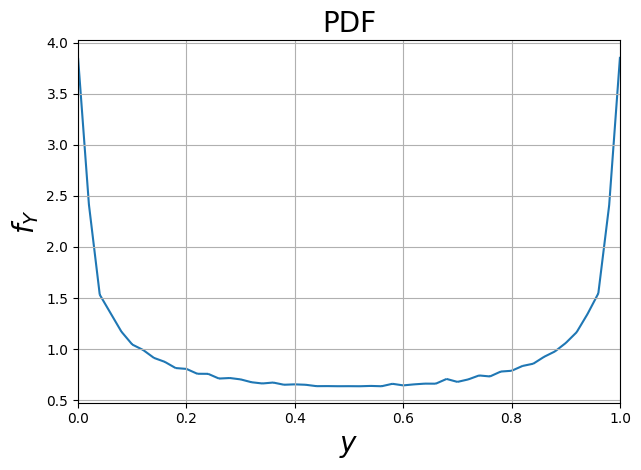

In [26]:
import matplotlib.pyplot as plt
from firedrake.pyplot import plot

plot(f,num_sample_points=50)
plt.title(r'PDF',fontsize=20)
plt.ylabel(r'$f_Y$',fontsize=20)
plt.xlabel(r'$y$',fontsize=20)
plt.tight_layout()
plt.xlim([0,1])
plt.grid()
plt.show()